In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
import galsim

from mdetsims import Sim
from metadetect.detect import MEDSifier
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG
from mdetsims.metacal import get_fofs, MOFFitter, MetacalFitter
from mdetsims.metacal.util import get_masked_frac

In [3]:
des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.263,
    psf_type='gauss',
    n_coadd=30,
    n_coadd_psf=1,
    gal_kws={'survey_name': 'DES'})

In [4]:
mbobs = des_sim.get_mbobs()

In [5]:
mfier = MEDSifier(
    mbobs=mbobs,
    sx_config=TEST_METACAL_MOF_CONFIG['sx'],
    meds_config=TEST_METACAL_MOF_CONFIG['meds'])

In [6]:
mbmeds = mfier.get_multiband_meds()

## Try the FoFs

In [7]:
res = get_fofs(mfier.cat, TEST_METACAL_MOF_CONFIG['fofs'])

100%|██████████| 41/41 [00:00<00:00, 24132.26it/s]


In [8]:
n_fofs = np.max(res[1]['fofid'])

In [9]:
for fofid in range(n_fofs):
    msk = res[1]['fofid'] == fofid
    if np.sum(msk) > 2:
        inds = res[1]['number'][msk] - 1
        list_of_mbobs = []
        for ind in inds:
            o = mbmeds.get_mbobs(ind)
            o[0].meta['Tsky'] = 1
            o.meta['masked_frac'] = get_masked_frac(o)
            o[0].meta['magzp_ref'] = 26.5
            o.meta['id'] = ind + 1
            o.meta['fofid'] = fofid
            list_of_mbobs.append(o)

In [10]:
list_of_mbobs

[[[<ngmix.observation.Observation at 0x11e61b048>]],
 [[<ngmix.observation.Observation at 0x11e61ba90>]],
 [[<ngmix.observation.Observation at 0x11e61b6d8>]],
 [[<ngmix.observation.Observation at 0x11e61b7b8>]]]

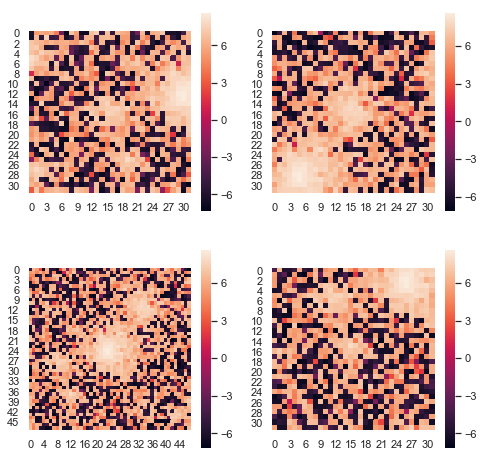

In [11]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(list_of_mbobs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(list_of_mbobs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(list_of_mbobs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(list_of_mbobs[3][0][0].image), square=True, ax=ax)

## Try MOF

In [ ]:
fitter = MOFFitter(TEST_METACAL_MOF_CONFIG, 1, np.random.RandomState(seed=10))

In [ ]:
od, ed = fitter.go(list_of_mbobs)

In [ ]:
mof_fitter = fitter.get_mof_fitter()

In [ ]:
rs = mof_fitter.make_corrected_obs()

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(rs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(rs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(rs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(rs[3][0][0].image), square=True, ax=ax)

## Try Metacal + MOF

In [12]:
rng = np.random.RandomState(seed=10)
nband = 1
mcal = MetacalFitter(
    TEST_METACAL_MOF_CONFIG, nband, rng, 
    mof_fitter=MOFFitter(TEST_METACAL_MOF_CONFIG, nband, rng))

In [13]:
mcal.go(list_of_mbobs)

array([(59.84017563, 126.8952179 , [-4.63560814e-05, -1.96069333e-05], 0.31609583, 36, 12.10482909, 12.14887743, [-1.20483310e-02, -1.54167491e-01,  1.08312241e-01, -4.54900979e-02,  3.54332874e-01,  1.67729597e+03], [[ 2.98226996e-03, -6.59540416e-05, -1.17226656e-05, -1.47919324e-05, -1.86239176e-06,  4.24689482e-03], [-6.59540416e-05,  3.71588628e-03, -6.73909120e-06, -1.50861385e-05, -1.32776260e-05, -2.42844029e-02], [-1.17226656e-05, -6.73909120e-06,  1.15319787e-02,  1.30165747e-03,  8.20160683e-05, -1.06629950e+00], [-1.47919324e-05, -1.50861385e-05,  1.30165747e-03,  1.87479972e-02, -3.81772597e-05,  1.50416446e-01], [-1.86239176e-06, -1.32776260e-05,  8.20160683e-05, -3.81772597e-05,  9.78153478e-03,  1.20361702e+01], [ 4.24689482e-03, -2.42844029e-02, -1.06629950e+00,  1.50416446e-01,  1.20361702e+01,  3.00984981e+04]], [ 0.10831224, -0.0454901 ], [[ 1.15319787e-02,  1.30165747e-03], [ 1.30165747e-03,  1.87479972e-02]], 0.35433287, 0.09890164, 1.12096661, 1677.29596946, [[0.

In [14]:
res = mcal.result

In [16]:
res.dtype

dtype([('x', '<f8'), ('y', '<f8'), ('mcal_psf_g', '<f8', (2,)), ('mcal_psf_T', '<f8'), ('mcal_nfev', '<i4'), ('mcal_s2n', '<f8'), ('mcal_s2n_r', '<f8'), ('mcal_pars', '<f8', (6,)), ('mcal_pars_cov', '<f8', (6, 6)), ('mcal_g', '<f8', (2,)), ('mcal_g_cov', '<f8', (2, 2)), ('mcal_T', '<f8'), ('mcal_T_err', '<f8'), ('mcal_T_ratio', '<f8'), ('mcal_flux', '<f8'), ('mcal_flux_cov', '<f8', (1, 1)), ('mcal_flux_err', '<f8'), ('mcal_nfev_1p', '<i4'), ('mcal_s2n_1p', '<f8'), ('mcal_s2n_r_1p', '<f8'), ('mcal_pars_1p', '<f8', (6,)), ('mcal_pars_cov_1p', '<f8', (6, 6)), ('mcal_g_1p', '<f8', (2,)), ('mcal_g_cov_1p', '<f8', (2, 2)), ('mcal_T_1p', '<f8'), ('mcal_T_err_1p', '<f8'), ('mcal_T_ratio_1p', '<f8'), ('mcal_flux_1p', '<f8'), ('mcal_flux_cov_1p', '<f8', (1, 1)), ('mcal_flux_err_1p', '<f8'), ('mcal_nfev_1m', '<i4'), ('mcal_s2n_1m', '<f8'), ('mcal_s2n_r_1m', '<f8'), ('mcal_pars_1m', '<f8', (6,)), ('mcal_pars_cov_1m', '<f8', (6, 6)), ('mcal_g_1m', '<f8', (2,)), ('mcal_g_cov_1m', '<f8', (2, 2)), ('m